<a href="https://colab.research.google.com/github/DrAlexSanz/Electricity-prices/blob/main/Time_series_stationality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

In [66]:
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [74]:
data = pd.read_csv('/gdrive/MyDrive/Electricity_prices/full_data.csv', parse_dates = True)
data["time"] = pd.to_datetime(data["time"]).dt.tz_convert(None)
data.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,snow_3h_Seville,clouds_all_Seville,temp_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,snow_3h_Valencia,clouds_all_Valencia
0,2014-12-31 23:00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,0.0,0,270.475,1001.0,77,1.0,62,0.0,0.0,0
1,2015-01-01 00:00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,0.0,0,270.475,1001.0,77,1.0,62,0.0,0.0,0
2,2015-01-01 01:00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,0.0,0,269.686,1002.0,78,0.0,23,0.0,0.0,0
3,2015-01-01 02:00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,0.0,0,269.686,1002.0,78,0.0,23,0.0,0.0,0
4,2015-01-01 03:00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,0.0,0,269.686,1002.0,78,0.0,23,0.0,0.0,0


## Several plots to check how the price looks like and the power generation too


*   Create a plotting function, give the df, the name of the column and it will generate the plot
*   Explore several plots.



In [75]:
def plot_column_time(df, column_name,
                label = None, ylabel = None, title = None, start=0, end = None):
    """
    Plots a column of the weather dataframe. The user can define either the 'df' and the 'column' 
    or the 'series' and additionally, can also define the 'label', the 
    'ylabel', the 'title', the 'start' and the 'end' of the plot.
    """
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    ax.plot(df[column_name][start:end], label=label)
    ax.set_ylabel(ylabel, fontsize=16)
    if ylabel:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

## Let's plot the power load in two weeks

For some reason the plot it's taking the index (date) position instead instead of the real value. I'll fix it later.

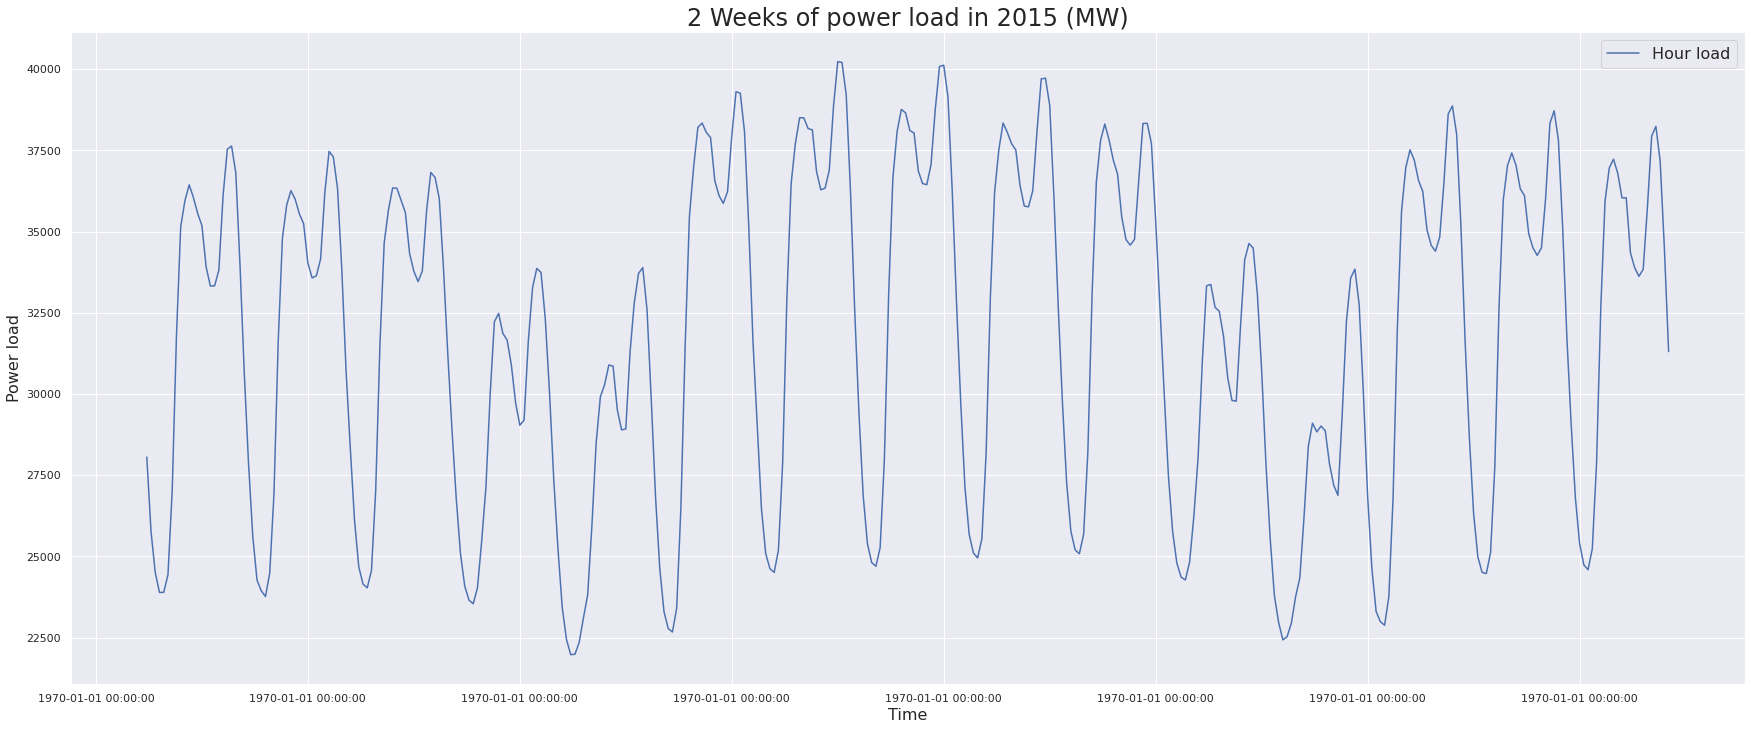

In [76]:
ax = plot_column(data, column_name = "total load actual", label = "Hour load", ylabel = "Power load",
                 start = 13*24, end = 24 * 28,
                 title = "2 Weeks of power load in 2015 (MW)")


plt.show()

## The days look as they should look like and that is a good sign.

Check here: [Red Eléctrica](https://www.ree.es/es)

There is the usual double hump in the middle of the day (typical winter) and there is also the difference between weekdays and weekends. Days and nights are very clear. Summer will have less obvious peaks.

## Now let's plot the price and the rolling month/week mean

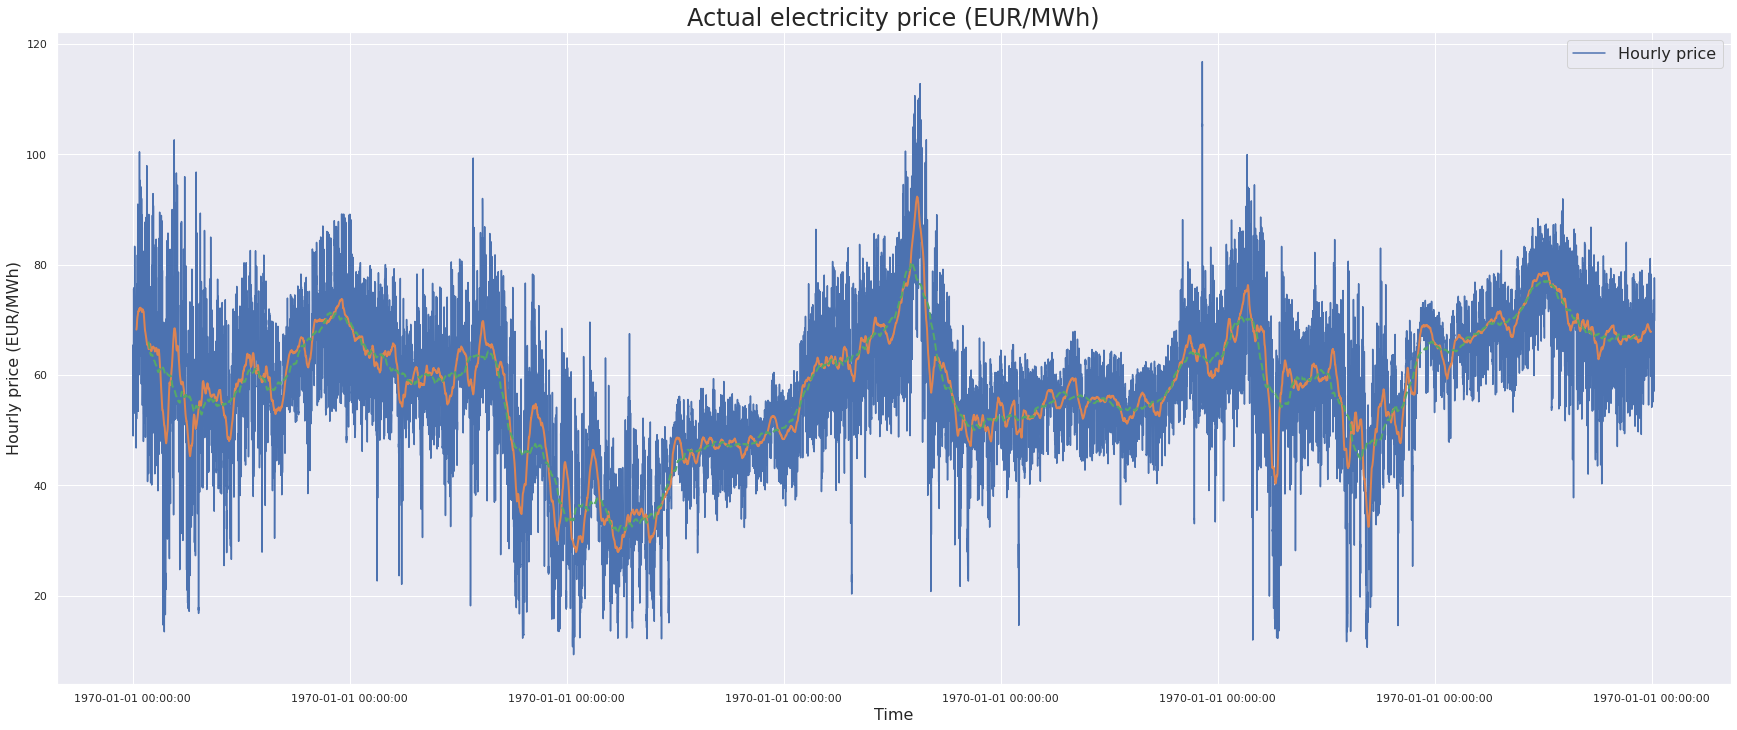

In [70]:
rolling_week = data["price actual"].rolling(24 * 7, center = True).mean()
rolling_month = data["price actual"].rolling(24 * 30, center = True).mean()

ax = plot_column(df = data, column_name = "price actual", label = "Hourly price", ylabel = "Hourly price (EUR/MWh)",
                 title = "Actual electricity price (EUR/MWh)")
ax.plot(rolling_week, linestyle = "-", linewidth = 2, label = "Price: 1 week rolling mean")
ax.plot(rolling_month, linestyle = "--", linewidth = 2, label = "Price: 30 days rolling mean")